# Nonlinear Kinetics

This tutorial extends the concepts introduced in the [Stationary Diffusion](stationary_diffusion.ipynb) and [Diffusion with First-Order Kinetics](diffusion_first_order_kinetics.ipynb) tutorials. Here, we will solve a nonlinear reaction-diffusion problem involving two components that react according to the equation:

$$A + B \rightarrow C$$

The governing equations for the concentrations of $A$ and $B$ are:

$$
\begin{align*}
\frac{\partial c_A}{\partial t} + \mathrm{div}(-D \nabla c_A) &= -k \, c_A c_B\\
\frac{\partial c_B}{\partial t} + \mathrm{div}(-D \nabla c_B) &= -k \, c_A c_B\\
\frac{\partial c_C}{\partial t} + \mathrm{div}(-D \nabla c_C) &= +k \, c_A c_B
\end{align*}
$$

Initially, none of the 3 species is present.
The boundary conditions are:
- $c_A(0) = 1$, ${\partial c_A(L)}/{\partial n} = 0$
- ${\partial c_B(0)}/{\partial n} = 0$, $c_B(L) = 1$
- $c_C(0) = 0$, $c_C(L) = 0$.



We will use the `NumJac` class from `PyMRM` to compute the Jacobian of the nonlinear reaction term and solve the system iteratively using Newton-Raphson.

In [1]:
import numpy as np
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, construct_coefficient_matrix, NumJac, newton

## Problem Setup

We define the physical parameters, boundary conditions, and the reaction kinetics.

In [ ]:
# Physical parameters
num_c = 3  # Number of components
L = 1.0    # Length of the domain
D = [[1.0, 1.0, 1.0]]    # Diffusion coefficients
k = 500    # Reaction rate constant

# Boundary conditions
bc_L = {'a': [[0, 1, 0]], 'b': [[1, 0, 1]], 'd': [[1, 0, 0]]}  # Dirichlet for A, Neumann for B, Dirichlet for C
bc_R = {'a': [[1, 0, 0]], 'b': [[0, 1, 1]], 'd': [[0, 1, 0]]}  # Neumann for A, Dirichlet for B, Dirichlet for C

# Reaction kinetics
def reaction(c, k):
    f = np.empty_like(c)
    r = k * c[..., 0] * c[..., 1]  # Reaction rate
    f[..., 0] = -r  # Loss of A
    f[..., 1] = -r  # Loss of B
    f[..., 2] = r   # Gain of C
    return f

## Numerical Setup

We discretize the domain and construct the gradient and divergence matrices for the diffusion term.

In [3]:
# Numerical parameters
dt = np.inf  # Time step size (infinity for steady state)
num_x = 100  # Number of grid points
shape = (num_x, num_c)  # Shape of the concentration array

# Grid setup
x_f = np.linspace(0, L, num_x + 1)  # Face positions
x_c = 0.5 * (x_f[:-1] + x_f[1:])  # Cell-centered positions

# Create accumulation matrix
accum_mat = construct_coefficient_matrix(1/dt, shape=shape) # Accumulation term

# Create and diffusion Jacobian matrix and boundary condition contribution
grad_mat, grad_bc = construct_grad(shape, x_f, x_c, bc=(bc_L, bc_R), axis=0)
D_mat = construct_coefficient_matrix(D, shape=shape, axis=0)
div_mat = construct_div(shape, x_f, nu=0, axis=0)
jac_diff    = div_mat @ (-D_mat @ grad_mat)  # Diffusion term
jac_diff_bc = div_mat @ (-D_mat @ grad_bc)   # Boundary condition contribution

## Solving Non-linear System using Newton's Method

The reaction term is non-linear, so we use the Newton-Raphson method to solve the system iteratively. This method is efficient, especially when the initial guess is close to the solution, as is often the case for unsteady problems. For steady-state problems, convergence may require additional techniques, such as starting with a time-dependent solution.

In Newton-Raphson, the system of equations is reformulated as a root-finding problem:

```python
g(c) = (c - c_old) / dt - div_mat @ (D_mat @ (grad_mat @ c + grad_bc)) - r(c)
```

The solution satisfies `g(c) = 0`. The method iteratively solves the linearized equation:

$$\mathbf{g}(\mathbf{c}^{(k+1)}) \approx \mathbf{g}(\mathbf{c}^{(k)}) + \mathbf{J} (\mathbf{c}^{(k+1)} - \mathbf{c}^{(k)})$$

where $\mathbf{J}$ is the Jacobian matrix of $\mathbf{g}$, defined as:

$$J_{ij} = \frac{\partial g_i}{\partial c_j}$$

The update step is:

$$\mathbf{c}^{(k+1)} = \mathbf{c}^{(k)} - \mathbf{J}^{-1} \mathbf{g}(\mathbf{c}^{(k)})$$

In `PyMRM`, the `newton` function simplifies this process by handling the iterative updates and convergence checks. It supports sparse Jacobians, making it suitable for large systems. The function requires:
- A callable that computes both `g(c)` and its Jacobian `J(c)`.
- An initial guess for `c`.
- Optional parameters like tolerance (`tol`) and maximum iterations (`maxfev`).
The `newton` function in `PyMRM` is designed to align with `scipy.optimize` conventions but adds support for sparse Jacobians, which are essential for solving large-scale problems efficiently.

Using the definitions above, we can write:
```python
g(c) = jac_accum @ (c - c_old) + jac_diff @ c + jac_diff_bc - r(c)
```
and the Jacobian:
```python
jac(c) = jac_accum + jac_diff - jac_react
```

Here, `jac_react` is the Jacobian of the reaction term, which changes with each iteration. The `NumJac` class in `PyMRM` efficiently computes this Jacobian using numerical differentiation. It automatically determines the sparsity pattern for multi-component systems when initialized with `c.shape`.

For example:
```python
numjac = NumJac(c.shape)
g_react, jac_react = numjac(lambda c: reaction(c, k), c)
```
This computes both the reaction term and its Jacobian efficiently.

### Solving the Nonlinear Diffusion-Reaction Problem

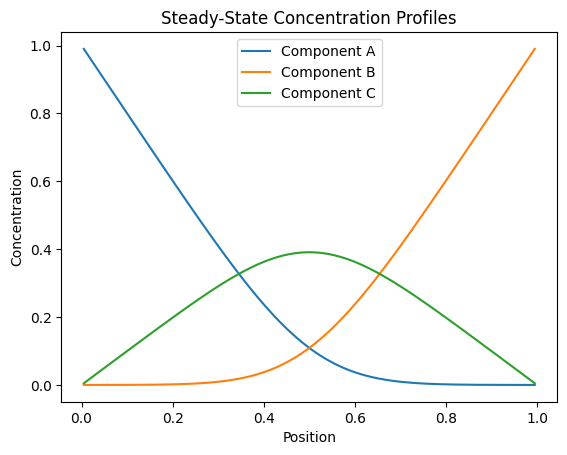

In [ ]:
# Initialize the NumJac class for numerical Jacobian computation
numjac = NumJac(shape)

# Define the residual function g(c, c_old)
def g(c, c_old):
    """
    Function to compute the residual of the system of equations.
    """
    # Reshape the concentration arrays for matrix operations
    c_vec = c.reshape((-1,1))
    c_old_vec = c_old.reshape((-1,1))
    
    # Compute the reaction term and its Jacobian
    g_react, jac_react = numjac(lambda c: reaction(c, k), c)
    
    # Compute the residual g and the Jacobian matrix
    g = accum_mat @ (c_vec - c_old_vec).reshape((-1,1)) + jac_diff @ c_vec + jac_diff_bc - g_react.reshape((-1,1))
    jac = accum_mat + jac_diff - jac_react
    
    return g, jac

# Initialize the concentration array with zeros
c_old = np.zeros(shape)

# Solve the nonlinear system using Newton's method
result = newton(lambda c: g(c, c_old), c_old, tol=1e-6, maxfev=10)

# Reshape the solution to the original shape
c = result.x.reshape(shape)

# Plot the steady-state concentration profiles
plt.plot(x_c, c[..., 0], label='Component A')  # Plot for component A
plt.plot(x_c, c[..., 1], label='Component B')  # Plot for component B
plt.plot(x_c, c[..., 2], label='Component C')  # Plot for component C
plt.xlabel('Position')  # Label for the x-axis
plt.ylabel('Concentration')  # Label for the y-axis
plt.legend()  # Add a legend to the plot
plt.title('Steady-State Concentration Profiles')  # Title of the plot
plt.show()  # Display the plot

## Exercise

Here are some suggestions to extend and experiment with the current implementation:

- **Vary Diffusion Coefficients**: Assign different diffusion coefficients to the components (e.g., `D = [[1.0, 0.5, 0.1]]`). Observe how the steady-state profiles change.

- **Modify Boundary Conditions**: Change the boundary conditions for one or more components.

- **Include a Reverse Reaction**: Add a reverse reaction term, such as $C \rightarrow A + B$, with a rate constant `k_rev`. Update the reaction function to include this reverse reaction.

- **Explore Convergence**: Experiment with different tolerances (`tol`) and maximum iterations (`maxfev`) in the `newton` function. Analyze how these parameters affect convergence and computation time.

- **Time-Dependent Solution**: Solve the system for a finite time step size (`dt`) instead of steady-state. Evolve the concentration profiles over time and visualize the transient behavior.

Feel free to implement these changes and observe how they impact the results!